# Deep neural network-based models for predicting mRNA editing (CNN)

Convolutional Neural Network with Mus musculus including activation map inspection

In [10]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, precision_score, cohen_kappa_score, classification_report
import seaborn as sns; sns.set()
from keras import backend as K
from keras.models import Sequential
from keract import get_activations,display_activations,display_heatmaps


In [11]:
########################################
# PARAMS
########################################
fname      = 'mm10_DL_Pad_W50_BALANCED_1_1_CODED2CH.csv'
separator_char=';'
categories=[['A','G','C','T'],['s','d','h','i','b']]
padding=True
ptrain     = 0.7
trace_level = 1
model_name = 'TFM_CNN_MM'
num_channels=256
kernel_width  = 9
n_epochs=40
batch_size=32
categories_size=20
cnn_dropout=0.4
random_seed=2022
########################################

We can run this notebook in two environments:
+ Googlr Colab Pro (Cloud)
+ Jupyter Lab (Locally)

In [12]:
#CHECK GOOGLE COLAB
GOOGLE_COLAB=False
if 'google.colab' in str(get_ipython()):
  GOOGLE_COLAB=True  
  print('Running on CoLab')
else:
  print('Not running on CoLab')

Not running on CoLab


Checking if GPU is available and GPU characteristics.

In [13]:
#CHECK GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Num GPUs Available: {}'.format(len(tf.config.list_physical_devices('GPU'))))
  print('Found GPU at: {}'.format(device_name))
  gpu_info = !nvidia-smi
  gpu_info = '\n'.join(gpu_info)
  if gpu_info.find('failed') >= 0:
     print('Not connected to a GPU')
  else:
     print(gpu_info)

Num GPUs Available: 1
Found GPU at: /device:GPU:0
Mon Sep 19 19:37:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.78       Driver Version: 512.78       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   49C    P8    N/A /  N/A |    164MiB /  2048MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                      

In [14]:
if padding==True:
    categories_size=categories_size+1

if GOOGLE_COLAB==False:
    data_dir = '../../data/datasets/ALL_MM/W50'
    models_dir = './SAVED_MODELS'

else:
    from google.colab import drive
    drive.mount('/content/drive')
    import sys
    #set the path to find RNAEd module
    sys.path.insert(0,'/content/drive/MyDrive/ColabNotebooks')    
    data_dir  = '/content/drive/MyDrive/DATASETS/ALL_MM/W50'
    models_dir= '/content/drive/MyDrive/MODELS'

In [15]:
from rnaed import DataGenerator,DataEncoding
encoding=DataEncoding(categories,padding=padding,pad_char="*")
n_ch,cat=encoding.getChannels()
print("Number of channels: {} /categories: {}".format(n_ch,cat))
encoding.print_LUT_TupleToInteger()
categories_size=encoding.getNumCodes()
print("Number of codes or categories size: {}".format(categories_size))

Number of channels: 2 /categories: [['A', 'G', 'C', 'T'], ['s', 'd', 'h', 'i', 'b']]
Number of codes=21
('A', 's') / 0
('A', 'd') / 1
('A', 'h') / 2
('A', 'i') / 3
('A', 'b') / 4
('G', 's') / 5
('G', 'd') / 6
('G', 'h') / 7
('G', 'i') / 8
('G', 'b') / 9
('C', 's') / 10
('C', 'd') / 11
('C', 'h') / 12
('C', 'i') / 13
('C', 'b') / 14
('T', 's') / 15
('T', 'd') / 16
('T', 'h') / 17
('T', 'i') / 18
('T', 'b') / 19
('*', '*') / 20
Number of codes or categories size: 21


In [16]:
#We can save best model and last model
best_model = 'best_model_'+model_name+'.h5'
last_model =  model_name+'.h5'
lastmodelfile = os.path.join(models_dir, last_model)
print("LAST MODEL FILE: {}".format(lastmodelfile))
bestmodelfile = os.path.join(models_dir, best_model)
print("BEST MODEL FILE: {}".format(bestmodelfile))
datafile = os.path.join(data_dir, fname)    

LAST MODEL FILE: ./SAVED_MODELS\TFM_CNN_MM.h5
BEST MODEL FILE: ./SAVED_MODELS\best_model_TFM_CNN_MM.h5


We read the data.

In [17]:
print("DATASET: {}".format(datafile))
data = pd.read_csv(datafile,sep=separator_char)
print("shape data={}".format(data.shape))

DATASET: ../../data/datasets/ALL_MM/W50\mm10_DL_Pad_W50_BALANCED_1_1_CODED2CH.csv
shape data=(59294, 104)


We will divide the data into: train, validation and test.
The three datastes should be well balanced.

In [18]:
print(data.head)

<bound method NDFrame.head of                        GENE    POS  EDITING  P1  P2  P3  P4  P5  P6  P7  ...  \
0       Ift140_Ift140_chr17  32742        0   6   1   1   1  16   6  16  ...   
1          Ip6k2_Ip6k2_chr9   5990        0  18  11   1  16  11  16  16  ...   
2         Cenpo_Cenpo_chr12   5245        0   6  16   0   0   6   6   1  ...   
3       Dusp22_Dusp22_chr13  49383        0  18   8   8  18   8  18  18  ...   
4      Atp6ap1_Atp6ap1_chrX   3884        0  16  16   6  16   6  11  15  ...   
...                     ...    ...      ...  ..  ..  ..  ..  ..  ..  ..  ...   
59289    Malsu1_Malsu1_chr6   2003        1   6   6  16   6  16   6   6  ...   
59290      Chst7_Chst7_chrX  13004        1  13   3   6   1  11   1  11  ...   
59291        Nptn_Nptn_chr9  48649        1  13   3  11  16  11  11   1  ...   
59292   Adarb1_Adarb1_chr10  31876        1   7  12  12   2   2   2   2  ...   
59293        Rpgr_Rpgr_chrX  24940        1  11   5  15  10  16   1  16  ...   

       P9

In [19]:
# Train and Validation+Test
data_train, data_val_test, data_y_train, data_y_val_test = train_test_split(data, data['EDITING'], test_size=1-ptrain, random_state=random_seed)
#Validation and test: 0.5/0.5
data_val, data_test, data_y_val, data_y_test = train_test_split(data_val_test, data_y_val_test, test_size=0.5, random_state=random_seed)

print("data_train:{} data_y_train:{}".format(data_train.shape,data_y_train.shape))
print("data_val: {} data_y_val: {}".format(data_val.shape,data_y_val.shape))
print("data_test: {} data_y_test: {}".format(data_test.shape,data_y_test.shape))
print("TRAIN LABELS:")
print(data_y_train.value_counts())
print("VALIDATION LABELS:")
print(data_y_val.value_counts())
print("TEST LABELS:")
print(data_y_test.value_counts())

data_train:(41505, 104) data_y_train:(41505,)
data_val: (8894, 104) data_y_val: (8894,)
data_test: (8895, 104) data_y_test: (8895,)
TRAIN LABELS:
1    20880
0    20625
Name: EDITING, dtype: int64
VALIDATION LABELS:
0    4513
1    4381
Name: EDITING, dtype: int64
TEST LABELS:
0    4509
1    4386
Name: EDITING, dtype: int64


We instantiate 3 DataGenerator objects that convert from integer to one-hot

In [20]:
#DataGenerator converts on the fly from raw data to one-hot
num_nucleosides = data_train.iloc[:,3:].shape[1]
num_tokens = categories_size

training_generator   = DataGenerator(data_train.iloc[:,3:], data_y_train, batch_size=batch_size, seq_size=num_nucleosides, categories_size=categories_size, shuffle=True)
validation_generator = DataGenerator(  data_val.iloc[:,3:], data_y_val,   batch_size=batch_size, seq_size=num_nucleosides, categories_size=categories_size, shuffle=True)
test_generator       = DataGenerator( data_test.iloc[:,3:], data_y_test,  batch_size=1,seq_size=num_nucleosides, categories_size=categories_size, shuffle=False )

## Model defined from the scratch

In [12]:
#MODELOS REDES NEURONALES CNN

model = Sequential(name=model_name)
#===============================================================
model.add(layers.Conv1D(num_channels, kernel_width, activation='relu',input_shape=(num_nucleosides, num_tokens),name="Conv1D_1"))
model.add(layers.Dropout(cnn_dropout,name="Dropout_1"))
model.add(layers.MaxPooling1D(5,name="MaxPool_1"))
#-------------------------------------------------
model.add(layers.Conv1D(num_channels,6, activation='relu',name="Conv1D_2"))
model.add(layers.Dropout(cnn_dropout,name="Dropout_2"))
model.add(layers.MaxPooling1D(5,name="MaxPool_2"))
#-------------------------------------------------
model.add(layers.Conv1D(num_channels,2, activation='relu',name="Conv1D_3"))
model.add(layers.Dropout(cnn_dropout,name="Dropout_3"))
model.add(layers.GlobalMaxPooling1D(name="GMaxPool_3"))
#-------------------------------------------------
model.add(layers.Dense(1, activation='sigmoid',name="DenseOutput"))
#===============================================================

In [13]:
#Mostramos el modelo
print(model.summary())

Model: "TFM_CNN_MM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1D_1 (Conv1D)           (None, 93, 256)           48640     
                                                                 
 Dropout_1 (Dropout)         (None, 93, 256)           0         
                                                                 
 MaxPool_1 (MaxPooling1D)    (None, 18, 256)           0         
                                                                 
 Conv1D_2 (Conv1D)           (None, 13, 256)           393472    
                                                                 
 Dropout_2 (Dropout)         (None, 13, 256)           0         
                                                                 
 MaxPool_2 (MaxPooling1D)    (None, 2, 256)            0         
                                                                 
 Conv1D_3 (Conv1D)           (None, 1, 256)            1

In [14]:
#Compilation reset all weights
model.compile(optimizer=keras.optimizers.Adam(),
              loss     =keras.losses.BinaryCrossentropy(),
              metrics  =[keras.metrics.BinaryAccuracy()])

Recover last model, best model or generate a new model

In [21]:
#Load the trained model from disk
import os.path

best_model_accuracy =0
last_model_accuracy =0


In [22]:
if os.path.exists(bestmodelfile):
    model = tf.keras.models.load_model(bestmodelfile)
    print("Testing best model file: {}".format(bestmodelfile))
    results = model.evaluate(validation_generator,verbose=1)
    best_model_accuracy = results[1]
    print("best model accuracy: {}".format(best_model_accuracy))    

Testing best model file: ./SAVED_MODELS\best_model_TFM_CNN_MM.h5
277/277 [==============================] - 23s 67ms/step - loss: 0.3857 - binary_accuracy: 0.8460
best model accuracy: 0.8460063338279724


In [23]:
if os.path.exists(lastmodelfile):
    model = tf.keras.models.load_model(lastmodelfile)
    print("Testing last complete model file: {}".format(lastmodelfile))
    results = model.evaluate(validation_generator,verbose=1)
    last_model_accuracy = results[1]
    print("last model accuracy: {}".format(last_model_accuracy))           


Testing last complete model file: ./SAVED_MODELS\TFM_CNN_MM.h5
277/277 [==============================] - 21s 77ms/step - loss: 0.3859 - binary_accuracy: 0.8460
last model accuracy: 0.8460063338279724


In [24]:
if best_model_accuracy >= last_model_accuracy and best_model_accuracy != 0:
   model = tf.keras.models.load_model(bestmodelfile)
   print("Selected best model saved: {}".format(bestmodelfile))
else:
  if last_model_accuracy > best_model_accuracy:
     print("Selected last model saved: {}".format(lastmodelfile))
  else:
     print("Selected new untrained model")

# Show the model architecture
model.summary()

Selected best model saved: ./SAVED_MODELS\best_model_TFM_CNN_MM.h5
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1D_1 (Conv1D)           (None, 93, 256)           48640     
                                                                 
 Dropout_1 (Dropout)         (None, 93, 256)           0         
                                                                 
 MaxPool_1 (MaxPooling1D)    (None, 18, 256)           0         
                                                                 
 Conv1D_2 (Conv1D)           (None, 13, 256)           393472    
                                                                 
 Dropout_2 (Dropout)         (None, 13, 256)           0         
                                                                 
 MaxPool_2 (MaxPooling1D)    (None, 2, 256)            0         
                                                     

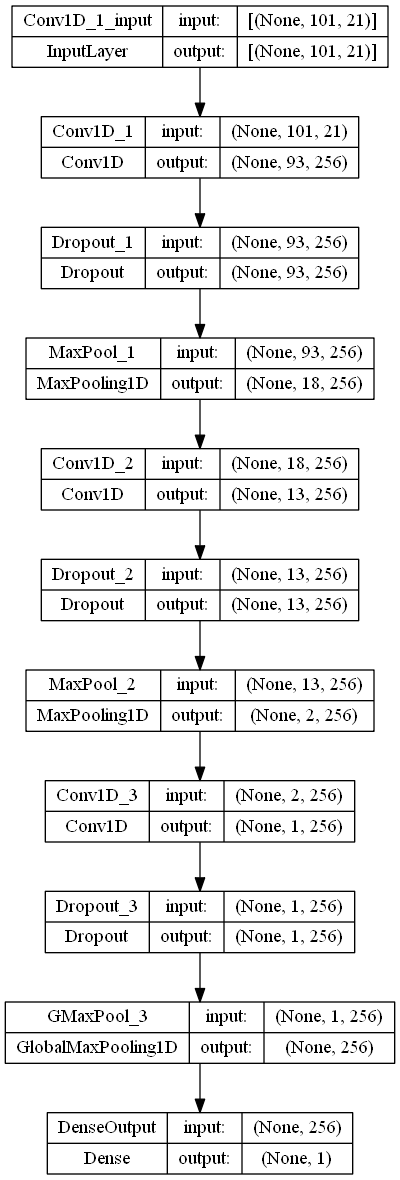

In [25]:
keras.utils.plot_model(model, show_shapes=True)

In [22]:
from keras.callbacks import ModelCheckpoint,EarlyStopping

checkpoint = ModelCheckpoint(bestmodelfile, 
                             monitor='val_loss', 
                             verbose=1,
                             save_best_only=True, 
                             mode='auto', 
                             save_freq='epoch')

callback=EarlyStopping(monitor='val_loss', 
                       min_delta=0, 
                       patience=3, 
                       verbose=1, 
                       mode='auto',
                       baseline=None, 
                       restore_best_weights=True)

In [ ]:
with tf.device(device_name):#Use GPU if available
    history=model.fit(training_generator,epochs=n_epochs,
                      validation_data=validation_generator,
                      callbacks=[checkpoint,callback],verbose=trace_level)

In [ ]:
#We always save the last model.
#Last model can be triggered by early stopping
n_epochs_trained = len(history.history['loss'])
print("Trained epochs: {} of {}".format(n_epochs_trained,n_epochs))
model.save(lastmodelfile)    

In [ ]:
#PLOT ACCURACY AND LOSS

acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

We recover the best model saved.

In [26]:
if os.path.exists(bestmodelfile):
    model = tf.keras.models.load_model(bestmodelfile)

We evaluate the best model on validation data.

In [27]:
#EVALUATE VALIDATION DATASET
print("Evaluate models on validation data")
results_model = model.evaluate(validation_generator,verbose=trace_level)
print ('Accuracy on validation data:',round(results_model[1],3))
print ('Loss on validation data:',round(results_model[0],3))

Evaluate models on validation data
277/277 [==============================] - 21s 75ms/step - loss: 0.3854 - binary_accuracy: 0.8461
Accuracy on validation data: 0.846
Loss on validation data: 0.385


We make predictions on test data, never used during training nor validation

In [28]:
#PREDICTIONS
print("Make predictions on test data")
model_prediction = model.predict(test_generator,verbose=trace_level)
model_prediction_binary = (model_prediction > 0.5).astype("int32")

Make predictions on test data
8895/8895 [==============================] - 29s 3ms/step


In [29]:
print(data_test.shape)
print(data_y_test.shape)
print(model_prediction.shape)
print(model_prediction_binary.shape)

(8895, 104)
(8895,)
(8895, 1)
(8895, 1)


In [30]:
#METRICS QUALITY CLASSIFICATION
print("MODEL "+model_name+"\n---------------------------------")
kappa = cohen_kappa_score(data_y_test, model_prediction_binary)
print ('Kappa:',round(kappa,3))
print(classification_report(data_y_test, model_prediction_binary))

MODEL TFM_CNN_MM
---------------------------------
Kappa: 0.692
              precision    recall  f1-score   support

           0       0.82      0.89      0.85      4509
           1       0.88      0.80      0.84      4386

    accuracy                           0.85      8895
   macro avg       0.85      0.85      0.85      8895
weighted avg       0.85      0.85      0.85      8895



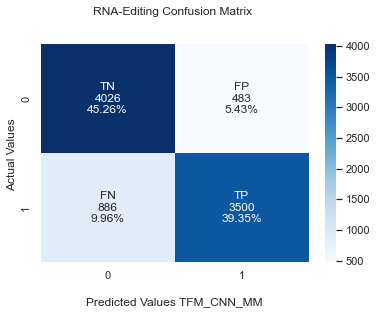

In [31]:
from sklearn.metrics import confusion_matrix, precision_score, cohen_kappa_score, classification_report
import seaborn as sns; sns.set()
# PLOT CONFUSION MATRIX
# Tutorial: https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/
plt.figure()

cm = confusion_matrix(data_y_test,model_prediction_binary)

group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

ax.set_title('RNA-Editing Confusion Matrix \n\n');
ax.set_xlabel('\nPredicted Values '+ model_name)
ax.set_ylabel('Actual Values ');
plt.show()


AUC: 0.91


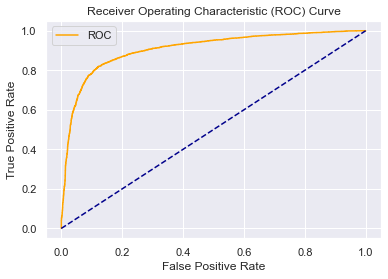

In [32]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color="orange", label="ROC")
    plt.plot([0, 1], [0, 1], color="darkblue", linestyle="--")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

auc = roc_auc_score(data_y_test, model_prediction)
print('AUC: %.2f' % auc)
fpr, tpr, thresholds = roc_curve(data_y_test, model_prediction)
plot_roc_curve(fpr, tpr)


# RESULTS INSIGHT

In [34]:
results_data = data_test
if 'RESULT_TYPE' not in results_data.columns:
    #insert column at position 3
    results_data.insert(3,"RESULT_TYPE", None)
    results_data.insert(4,"PROB_PRED",model_prediction)
else:
    print("RESULT_TYPE already exists in the dataframe")

results_data.head()

,GENE,POS,EDITING,RESULT_TYPE,PROB_PRED,P1,P2,P3,P4,P5,...,P92,P93,P94,P95,P96,P97,P98,P99,P100,P101
34743,H2afy_H2afy_chr13,48924,0,None,0.042782,11,16,6,11,7,...,12,12,2,7,17,17,2,17,7,2
50220,Ttc39b_Ttc39b_chr4,22505,0,None,0.118942,12,7,2,2,17,...,0,0,0,0,0,0,15,5,15,5
36286,C1galt1_C1galt1_chr6,3881,0,None,0.272920,17,12,17,7,7,...,5,15,15,15,10,0,0,15,0,0
34597,Alkbh3_Alkbh3_chr2,15671,0,None,0.039052,6,11,11,11,11,...,13,11,1,11,1,11,11,6,1,11
9117,Trub2_Trub2_chr2,9700,1,None,0.906185,6,6,19,6,6,...,11,11,6,6,3,11,6,6,1,9


In [35]:
column_index=results_data.columns.get_loc('RESULT_TYPE')
i=0
for result in model_prediction_binary:
    #print("Comparing result={} with data_y_test={}".format(result[0],data_y_test.iloc[i]))
    if   result[0]==0 and data_y_test.iloc[i]==0:
       typeRes ="TN"
    elif result[0]==0 and data_y_test.iloc[i]==1:
       typeRes="FN"
    elif result[0]==1 and data_y_test.iloc[i]==0:
       typeRes="FP"
    elif result[0]==1 and data_y_test.iloc[i]==1:
       typeRes="TP"
    results_data.iloc[i, column_index]=typeRes
    i+=1
    
results_data.head()

,GENE,POS,EDITING,RESULT_TYPE,PROB_PRED,P1,P2,P3,P4,P5,...,P92,P93,P94,P95,P96,P97,P98,P99,P100,P101
34743,H2afy_H2afy_chr13,48924,0,TN,0.042782,11,16,6,11,7,...,12,12,2,7,17,17,2,17,7,2
50220,Ttc39b_Ttc39b_chr4,22505,0,TN,0.118942,12,7,2,2,17,...,0,0,0,0,0,0,15,5,15,5
36286,C1galt1_C1galt1_chr6,3881,0,TN,0.272920,17,12,17,7,7,...,5,15,15,15,10,0,0,15,0,0
34597,Alkbh3_Alkbh3_chr2,15671,0,TN,0.039052,6,11,11,11,11,...,13,11,1,11,1,11,11,6,1,11
9117,Trub2_Trub2_chr2,9700,1,TP,0.906185,6,6,19,6,6,...,11,11,6,6,3,11,6,6,1,9


In [36]:
#Save the results into a file
report_dir="./report"
results_csv_file  =model_name + "_Results.csv"
results_excel_file=model_name + "_Results.xlsx"
results_data.to_csv(os.path.join(report_dir,results_csv_file))
results_data.to_excel(os.path.join(report_dir,results_excel_file))

Now, we are going to find the record with highest probability and category TP (True Positive) as a good model of TP data,
and alternatively, the best representative of TN, using the lowest value

In [37]:
subset_TP=results_data.loc[results_data['RESULT_TYPE'] == 'TP']
prototype_of_TP_id=subset_TP['PROB_PRED'].idxmax()
print("rowid best TP = {}".format(prototype_of_TP_id))
print(results_data.loc[prototype_of_TP_id,])

rowid best TP = 13115
GENE           Cnrip1_Cnrip1_chr11
POS                          19250
EDITING                          1
RESULT_TYPE                     TP
PROB_PRED                 0.999997
                      ...         
P97                             10
P98                              0
P99                              0
P100                             5
P101                            15
Name: 13115, Length: 106, dtype: object


In [38]:
subset_TN=results_data.loc[results_data['RESULT_TYPE'] == 'TN']
prototype_of_TN_id=subset_TN['PROB_PRED'].idxmin()
print("rowid best TN = {}".format(prototype_of_TN_id))
print(results_data.loc[prototype_of_TN_id,])

rowid best TN = 21141
GENE           Gm32017_Gm32017_chr9
POS                           43238
EDITING                           0
RESULT_TYPE                      TN
PROB_PRED                  0.000265
                       ...         
P97                              12
P98                               2
P99                               7
P100                             17
P101                             17
Name: 21141, Length: 106, dtype: object


Now we inspect the activations of these two samples

In [42]:
x_TP = results_data.loc[prototype_of_TP_id,'P1':]
y_TP = results_data.loc[prototype_of_TP_id,'EDITING']
print(x_TP)
print("EDITING={}".format(y_TP))

#Convert to int32
x_TP = np.asarray(x_TP).astype('float32')
tensor_TP = tf.constant(x_TP)
X_TP_tensor=tf.keras.layers.CategoryEncoding(num_tokens=categories_size, output_mode="one_hot")(tensor_TP).numpy()
print(X_TP_tensor)
#Convert from [101,21] to [1,101,21]
X_TP_tensor=tf.reshape(X_TP_tensor, [1,X_TP_tensor.shape[0],X_TP_tensor.shape[1]])
activations_TP = get_activations(model, X_TP_tensor)

P1      17
P2       7
P3       2
P4       7
P5       2
        ..
P97     10
P98      0
P99      0
P100     5
P101    15
Name: 13115, Length: 101, dtype: object
EDITING=1
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [48]:
directory_img_TP_name_activations=model_name + '_directory'+'_TP_activations'
directory_img_TP_name_heatmaps   =model_name + '_directory'+'_TP_heatmaps'

directory_img_TP_activations=os.path.join(report_dir,directory_img_TP_name_activations)
directory_img_TP_heatmaps   =os.path.join(report_dir,directory_img_TP_name_heatmaps)

directory_img_TN_name_activations=model_name + '_directory'+'_TN_activations'
directory_img_TN_name_heatmaps   =model_name + '_directory'+'_TN_heatmaps'

directory_img_TN_activations=os.path.join(report_dir,directory_img_TN_name_activations)
directory_img_TN_heatmaps   =os.path.join(report_dir,directory_img_TN_name_heatmaps)



In [44]:
display_activations(activations_TP, save=True, directory=directory_img_TP_activations,data_format="channels_first")

Conv1D_1_input (1, 101, 21) 
Conv1D_1 (1, 93, 256) 
Dropout_1 (1, 93, 256) 
MaxPool_1 (1, 18, 256) 
Conv1D_2 (1, 13, 256) 
Dropout_2 (1, 13, 256) 
MaxPool_2 (1, 2, 256) 
Conv1D_3 (1, 1, 256) 
Dropout_3 (1, 1, 256) 
GMaxPool_3 (1, 256) 
DenseOutput (1, 1) 


In [47]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
X_TP_tensor=tf.keras.layers.CategoryEncoding(num_tokens=categories_size, output_mode="one_hot")(tensor_TP).numpy()

display_heatmaps(activations_TP, X_TP_tensor, directory=directory_img_TP_heatmaps, save=True)

Conv1D_1_input (1, 101, 21) 
Conv1D_1 (1, 93, 256) 
Dropout_1 (1, 93, 256) 
MaxPool_1 (1, 18, 256) 
Conv1D_2 (1, 13, 256) 
Dropout_2 (1, 13, 256) 
MaxPool_2 (1, 2, 256) 
Conv1D_3 (1, 1, 256) 
Dropout_3 (1, 1, 256) 
GMaxPool_3 (1, 256) -> Skipped. 2D Activations.
DenseOutput (1, 1) -> Skipped. 2D Activations.


In [49]:
x_TN = results_data.loc[prototype_of_TN_id,'P1':]
y_TN = results_data.loc[prototype_of_TN_id,'EDITING']
print(x_TN)
print("EDITING={}".format(y_TN))

#Convertimos a int32
x_TN = np.asarray(x_TN).astype('float32')
tensor_TN = tf.constant(x_TN)
X_TN_tensor=tf.keras.layers.CategoryEncoding(num_tokens=categories_size, output_mode="one_hot")(tensor_TN).numpy()
print(X_TN_tensor)
#Convert from [101,21] to [1,101,21]
X_TN_tensor=tf.reshape(X_TN_tensor, [1,X_TN_tensor.shape[0],X_TN_tensor.shape[1]])
activations_TN = get_activations(model, X_TN_tensor)

display_activations(activations_TN, save=True, directory=directory_img_TN_activations)
X_TN_tensor=tf.keras.layers.CategoryEncoding(num_tokens=categories_size, output_mode="one_hot")(tensor_TN).numpy()
display_heatmaps(activations_TP, X_TN_tensor, directory=directory_img_TN_heatmaps, save=True)

P1       2
P2      12
P3       2
P4      12
P5       2
        ..
P97     12
P98      2
P99      7
P100    17
P101    17
Name: 21141, Length: 101, dtype: object
EDITING=0
[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Conv1D_1_input (1, 101, 21) 
Conv1D_1 (1, 93, 256) 
Dropout_1 (1, 93, 256) 
MaxPool_1 (1, 18, 256) 
Conv1D_2 (1, 13, 256) 
Dropout_2 (1, 13, 256) 
MaxPool_2 (1, 2, 256) 
Conv1D_3 (1, 1, 256) 
Dropout_3 (1, 1, 256) 
GMaxPool_3 (1, 256) 
DenseOutput (1, 1) 
Conv1D_1_input (1, 101, 21) 
Conv1D_1 (1, 93, 256) 
Dropout_1 (1, 93, 256) 
MaxPool_1 (1, 18, 256) 
Conv1D_2 (1, 13, 256) 
Dropout_2 (1, 13, 256) 
MaxPool_2 (1, 2, 256) 
Conv1D_3 (1, 1, 256) 
Dropout_3 (1, 1, 256) 
GMaxPool_3 (1, 256) -> Skipped. 2D Activations.
DenseOutput (1, 1) -> Skipped. 2D Activations.


In [50]:
print(activations_TP["Conv1D_1"])
print(activations_TP["Conv1D_2"])
print(activations_TP["Conv1D_3"])

[[[0.40948552 0.         0.         ... 0.         0.         0.        ]
  [0.03334367 0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  ...
  [0.         0.11681233 0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]]]
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
[[[0.         0.         0.         0.         1.1969492  0.
   0.         0.         0.         2.3536913  0.         0.
   0.         0.         0.         0.         0.         1.0467734
   0.         0.         1.8608013  2.887939   1.0945615  6.675517
   5.362056   0.         0.         0.         0.         0.
   0.         7.861216   0.         0.44017276 0.         2.766008